In [52]:
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from wxdata.plotting import (
    simple_basemap, sample_colors, plot_cities, LegendBuilder, plot_points, plot_time_progression,
    datetime_buckets
)

env: WORKDIR=~/Documents/weatherpy-work/


## Load the tornado data for 4/14/12 and find the clusters

In [2]:
df = stormevents.tornadoes('2012-04-14 12:00', '2012-04-15 12:00', tz='UTC')

In [84]:
clusters = stormevents.clust.st_clusters(df, eps_km=60, eps_min=60, min_samples=15)

## Plot the clusters

Three notable cities were affected by the tornado outbreak:
* Wichita, KS (hit by an EF3 tornado; 38 injuries)
* Salina, KS (narrowly avoided being hit by an EF4 tornado)
* Woodward, OK (hit by an EF3 tornado; six fatalities)
* Creston, IA (hit by an EF2 tornado; 10 injuries)

For convenience, these cities will be plotted.

Other larger cities and locations with WFO's in the Great Plains will be plotted as well.

In [4]:
cities = {
    'Wichita': (37.69, -97.33),
    'Salina': (38.84, -97.61),
    'Woodward': (36.43, -99.39),
    'Creston': (41.06, -94.36),
    
    'Dodge City': (37.75, -100.02),
    'Hays': (38.88, -99.33),
    'Kansas City': (39.10, -94.56),
    'Omaha': (41.25, -96.00),
    'North Platte': (41.14, -100.76),
    'Hastings': (40.59, -98.39)
}

In [13]:
import matplotlib.patheffects as path_effects
from wxdata.plotting import bottom_right_textbox

def watermark(fig):
    bottom_right_textbox(fig.axes[0], 'Graphic created by Jim Tang (@wxmann)')
    
shadow = path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.6)
    
def plot_clusters(cluster_groups, basemap, cluster_colors, noise_color='gray'):    
    leg = LegendBuilder()

    for clust in cluster_groups.clusters:
        color = cluster_colors[clust.index]
        plot_points(clust.pts, basemap, color, markersize=1.5, path_effects=[shadow])
        leg.append(color, clust.describe_tors())

    noise = cluster_groups.noise
    plot_points(noise.pts, basemap, markersize=1.5, color=noise_color, path_effects=[shadow])
    leg.append(noise_color, noise.describe_tors())
    
    leg.plot_legend()

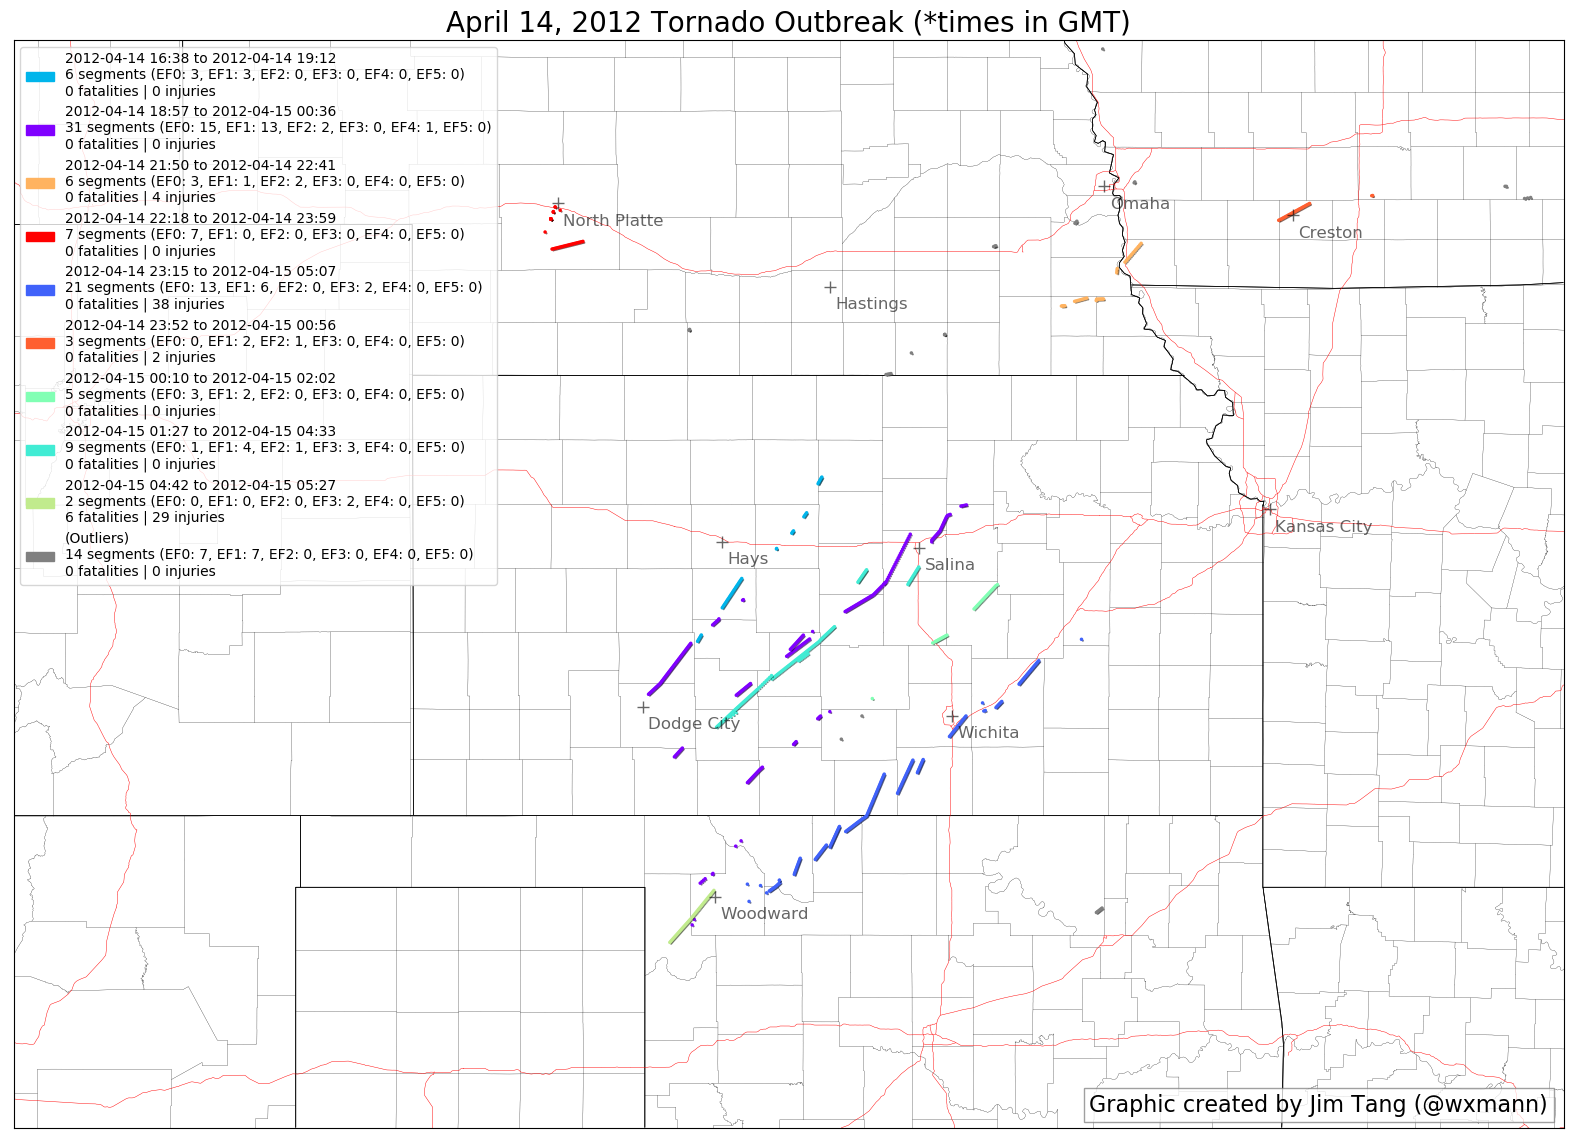

In [83]:
fig = plt.figure(figsize=(20, 20), dpi=100)

bbox = (-105.5, -92, 34.8, 42.2)
colors = sample_colors(len(clusters), 'rainbow')
bg_map = simple_basemap(bbox, proj='merc')
plot_clusters(clusters, bg_map, colors)

plt.title('April 14, 2012 Tornado Outbreak (*times in GMT)', fontsize=20)
watermark(fig)
plot_cities(cities, bg_map)
plt.show()

## Plot individual tornado clusters (OK-KS)

#### Some convenience functions for the plotting, to maintain each plot has the same look-and-feel and zooms in on the same sector. Base functions are buried in the modules.

In [72]:
from wxdata.plotting import plot_time_progression

ks_cities = {k: v for k, v in cities.items() 
             if k in ('Dodge City', 'Hays', 'Salina', 'Wichita', 'Woodward')}

def zoomed_in_map():
    bbox = (-102.25, -94.25, 35.5, 39.75)
    basemap = simple_basemap(bbox, proj='merc')
    plot_cities(ks_cities, basemap, dx=0.05, dy=-0.08, labelsize=12, color='k')
    return basemap

def plot_bg_tornadoes(cluster_groups, not_bg_clust, basemap):
    for clust in cluster_groups.clusters:
        if clust != not_bg_clust:
            plot_points(clust.pts, basemap, 'lightgray', markersize=1.5, alpha=0.6)
    
    plot_points(cluster_groups.noise.pts, basemap, 'lightgray', markersize=1.5, alpha=0.6)
    
def time_progression_label(a, b):
    return '{} to {} UTC'.format(a.strftime('%H:%M'), b.strftime('%H:%M'))

def plot_cluster_progression(cluster, cluster_group, time_buckets):
    leg = LegendBuilder(loc=2, fontsize='large')
    plot_time_progression(cluster.pts, zoomed_in_map(), time_buckets, 'viridis', markersize=3.5, legend=leg,
                         legend_handle_func=time_progression_label,
                         path_effects=[shadow])
    plot_bg_tornadoes(cluster_group, cluster, basemap)

    leg.append(color='lightgray', label='(Other Tornadoes)', alpha=0.6)
    leg.plot_legend()

### Early afternoon supercell: east of Hays

In [89]:
clust0 = clusters.clusters[0]
clust0.summary()

{'center': (38.710409259259265, -99.03848888888886),
 'max_time': Timestamp('2012-04-14 19:11:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 16:38:00+0000', tz='UTC'),
 'size': 54,
 'time_spread': Timedelta('0 days 02:33:00')}

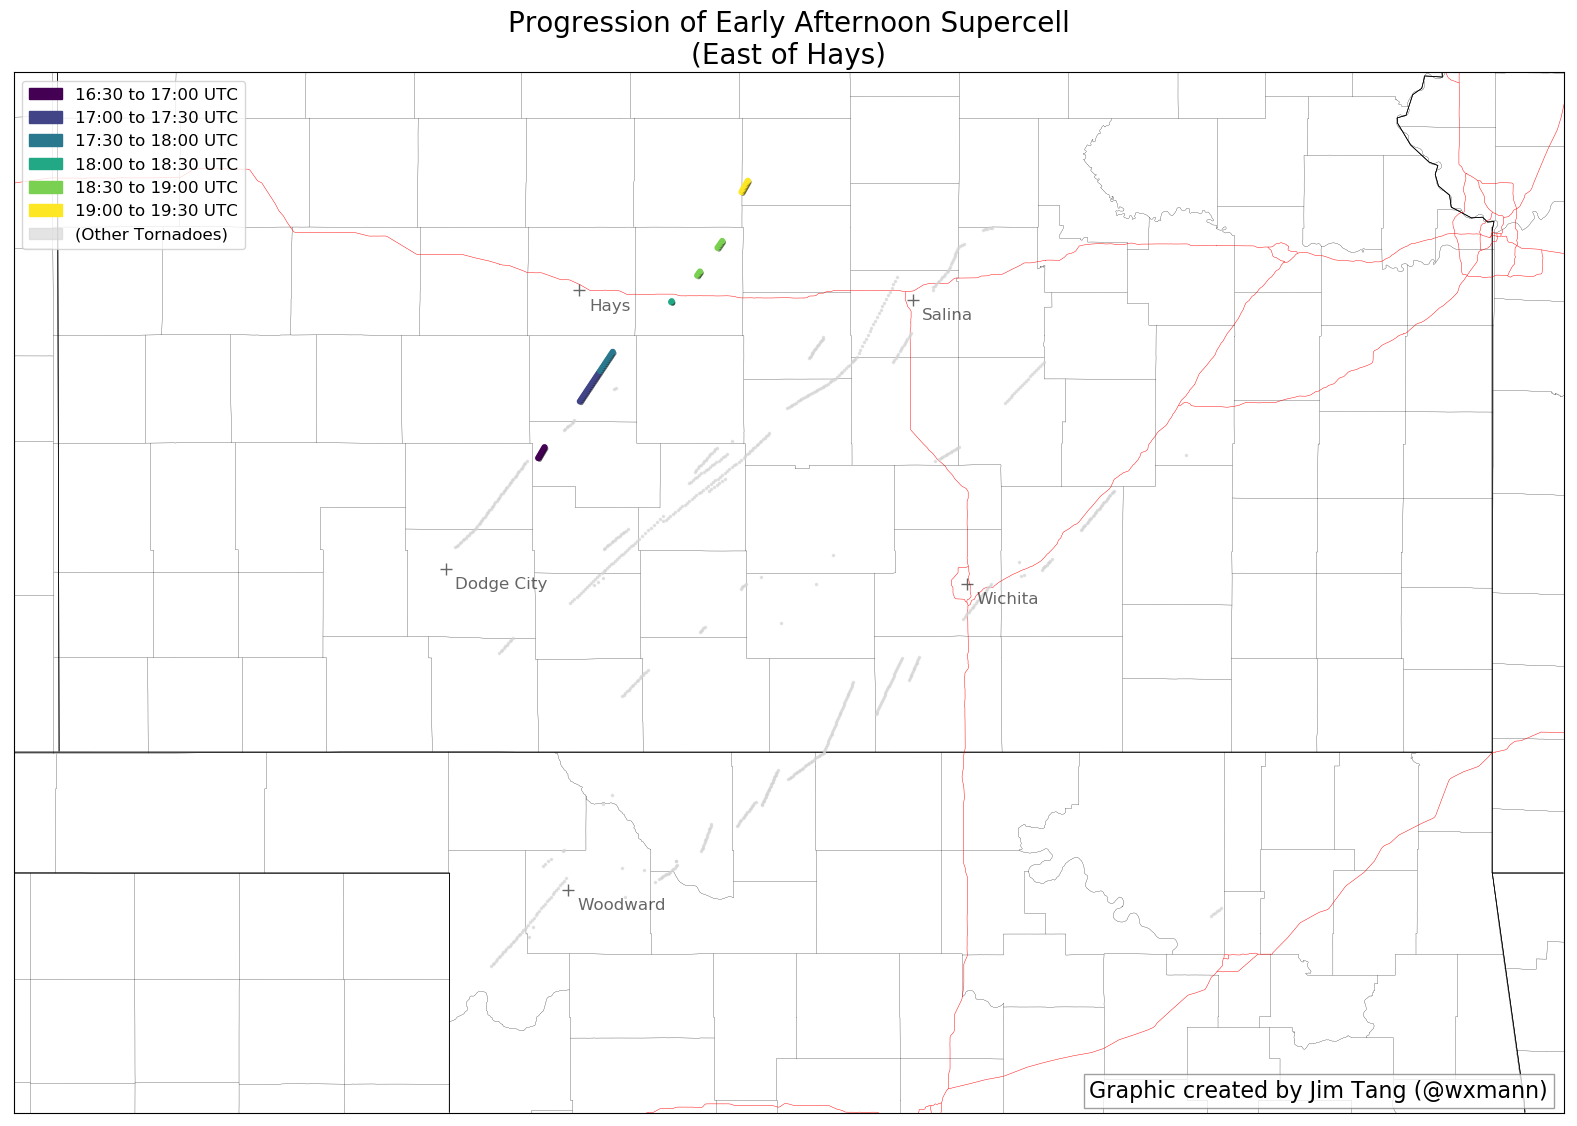

In [91]:
fig = plt.figure(figsize=(20, 20), dpi=100)

min_time = pd.Timestamp('2012-04-14 16:30+0000')
max_time = pd.Timestamp('2012-04-14 19:30+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

plot_cluster_progression(clust0, clusters, time_buckets)

plt.title('Progression of Early Afternoon Supercell'
          '(East of Hays)',
         fontsize=20)
watermark(fig)
plt.show()

### First round of supercells: DDC - SLN - north of WWD

In [77]:
clust1 = clusters.clusters[1]
clust1.summary()

{'center': (38.16995096899226, -98.72926434108527),
 'max_time': Timestamp('2012-04-15 00:35:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 18:57:00+0000', tz='UTC'),
 'size': 258,
 'time_spread': Timedelta('0 days 05:38:00')}

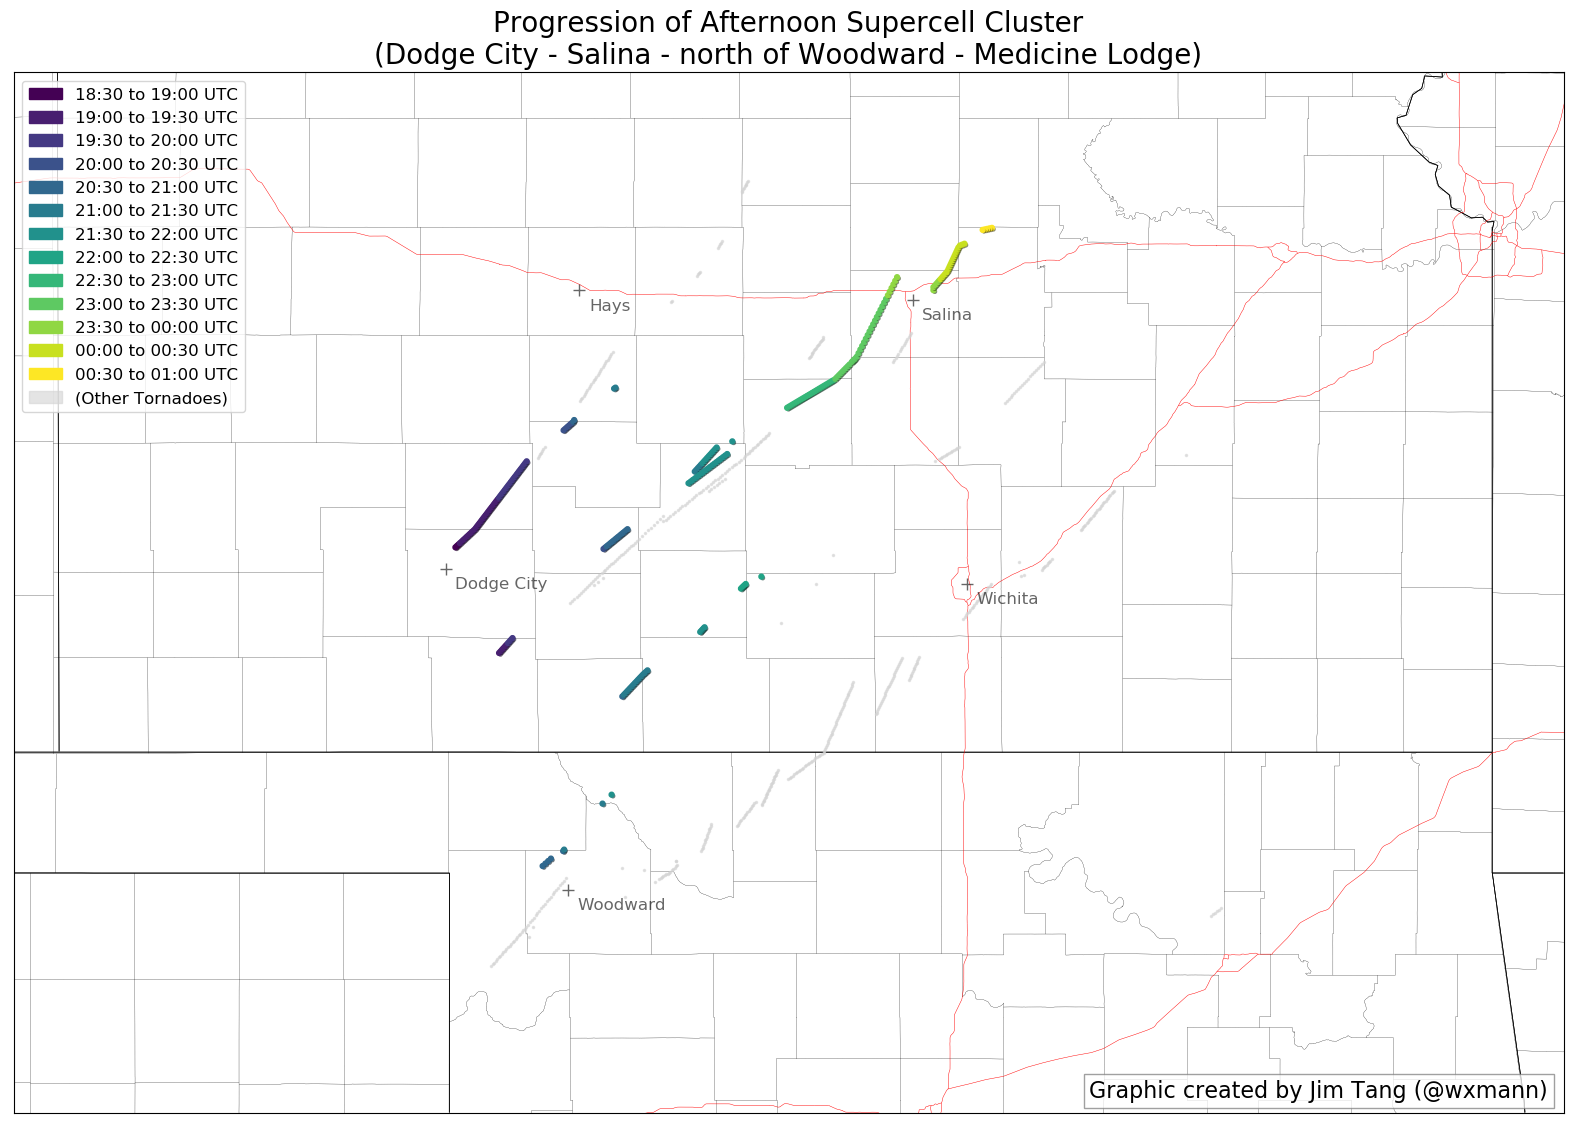

In [78]:
fig = plt.figure(figsize=(20, 20), dpi=100)

min_time = pd.Timestamp('2012-04-14 18:30+0000')
max_time = pd.Timestamp('2012-04-15 01:00+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

plot_cluster_progression(clust1, clusters, time_buckets)

plt.title('Progression of Afternoon Supercell Cluster'
          '\n(Dodge City - Salina - north of Woodward - Medicine Lodge)',
         fontsize=20)
watermark(fig)
plt.show()

### Prolific Southern Supercell: ~Woodward - Wichita

In [74]:
clust4 = clusters.clusters[4]
clust4.summary()

{'center': (37.17572088353416, -97.88072550200805),
 'max_time': Timestamp('2012-04-15 05:06:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 22:18:00+0000', tz='UTC'),
 'size': 249,
 'time_spread': Timedelta('0 days 06:48:00')}

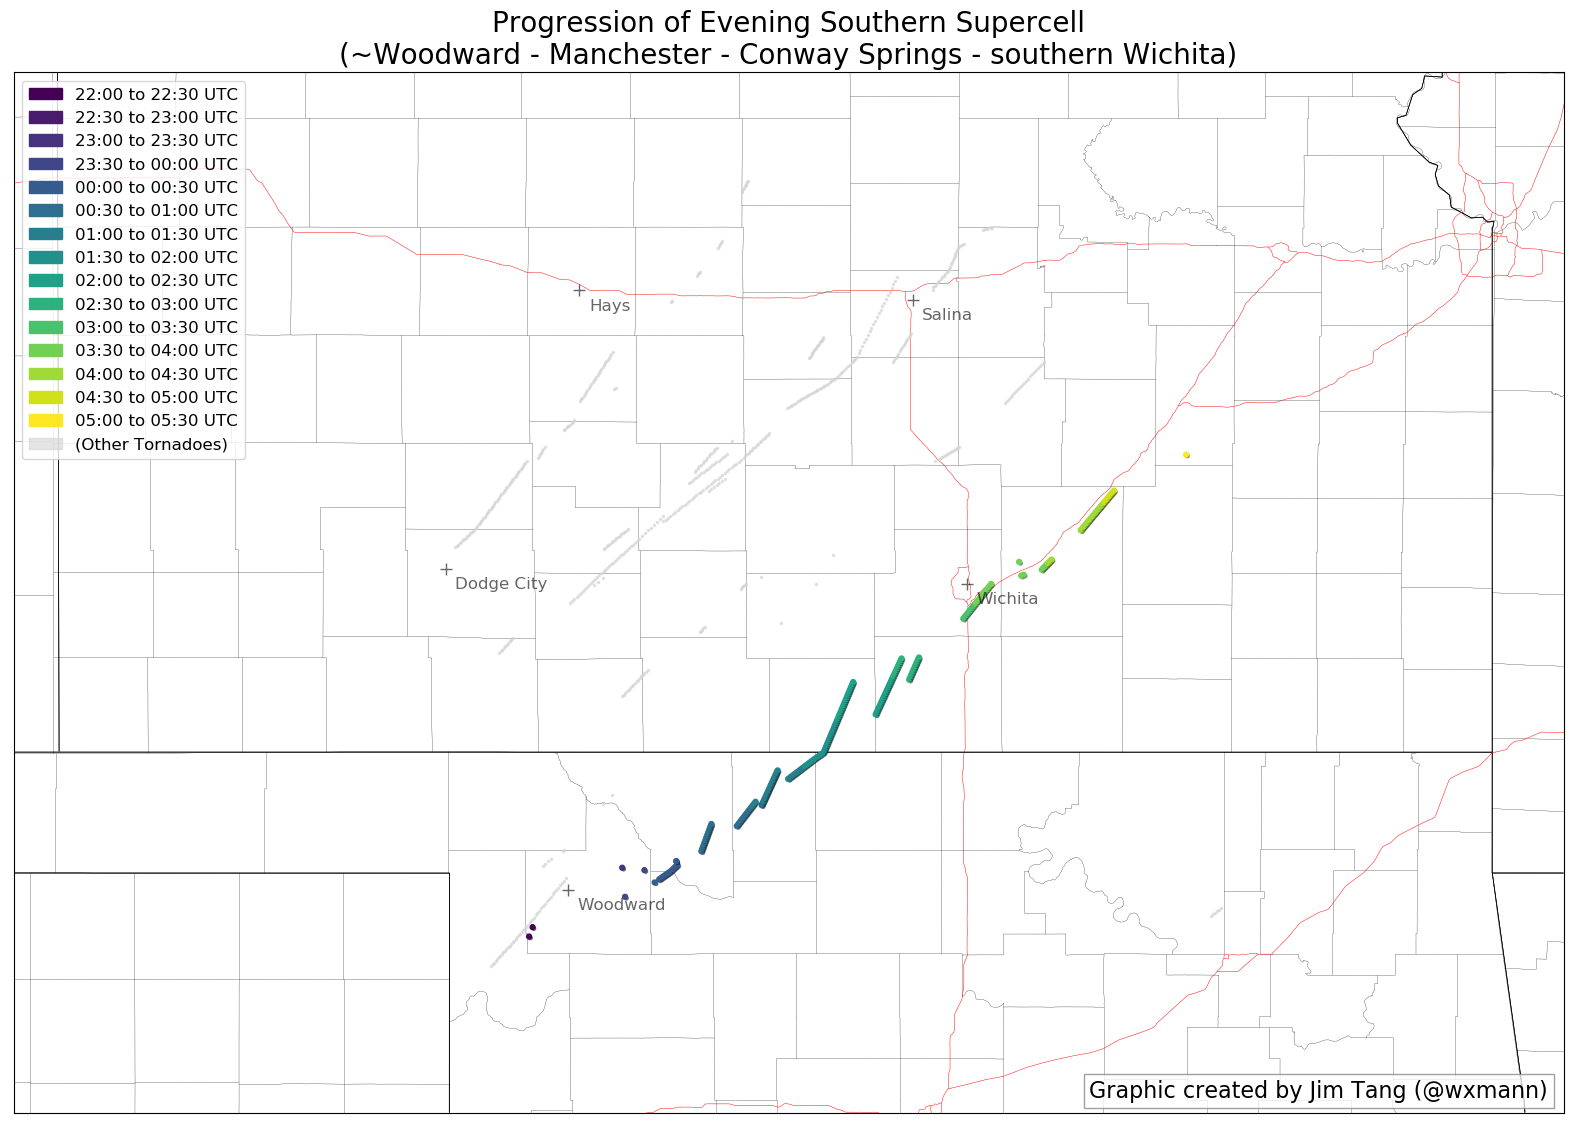

In [86]:
fig = plt.figure(figsize=(20, 20), dpi=100)

min_time = pd.Timestamp('2012-04-14 22:00+0000')
max_time = pd.Timestamp('2012-04-15 05:30+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

plot_cluster_progression(clust4, clusters, time_buckets)

plt.title('Progression of Evening Southern Supercell'
          '\n(~Woodward - Manchester - Conway Springs - southern Wichita)',
         fontsize=20)
watermark(fig)
plt.show()

### Reborn Afternoon Supercell: Hesston - Marion

In [93]:
clust6 = clusters.clusters[6]
clust6.summary()

{'center': (38.39264285714286, -97.19108571428568),
 'max_time': Timestamp('2012-04-15 02:01:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-15 01:03:00+0000', tz='UTC'),
 'size': 35,
 'time_spread': Timedelta('0 days 00:58:00')}

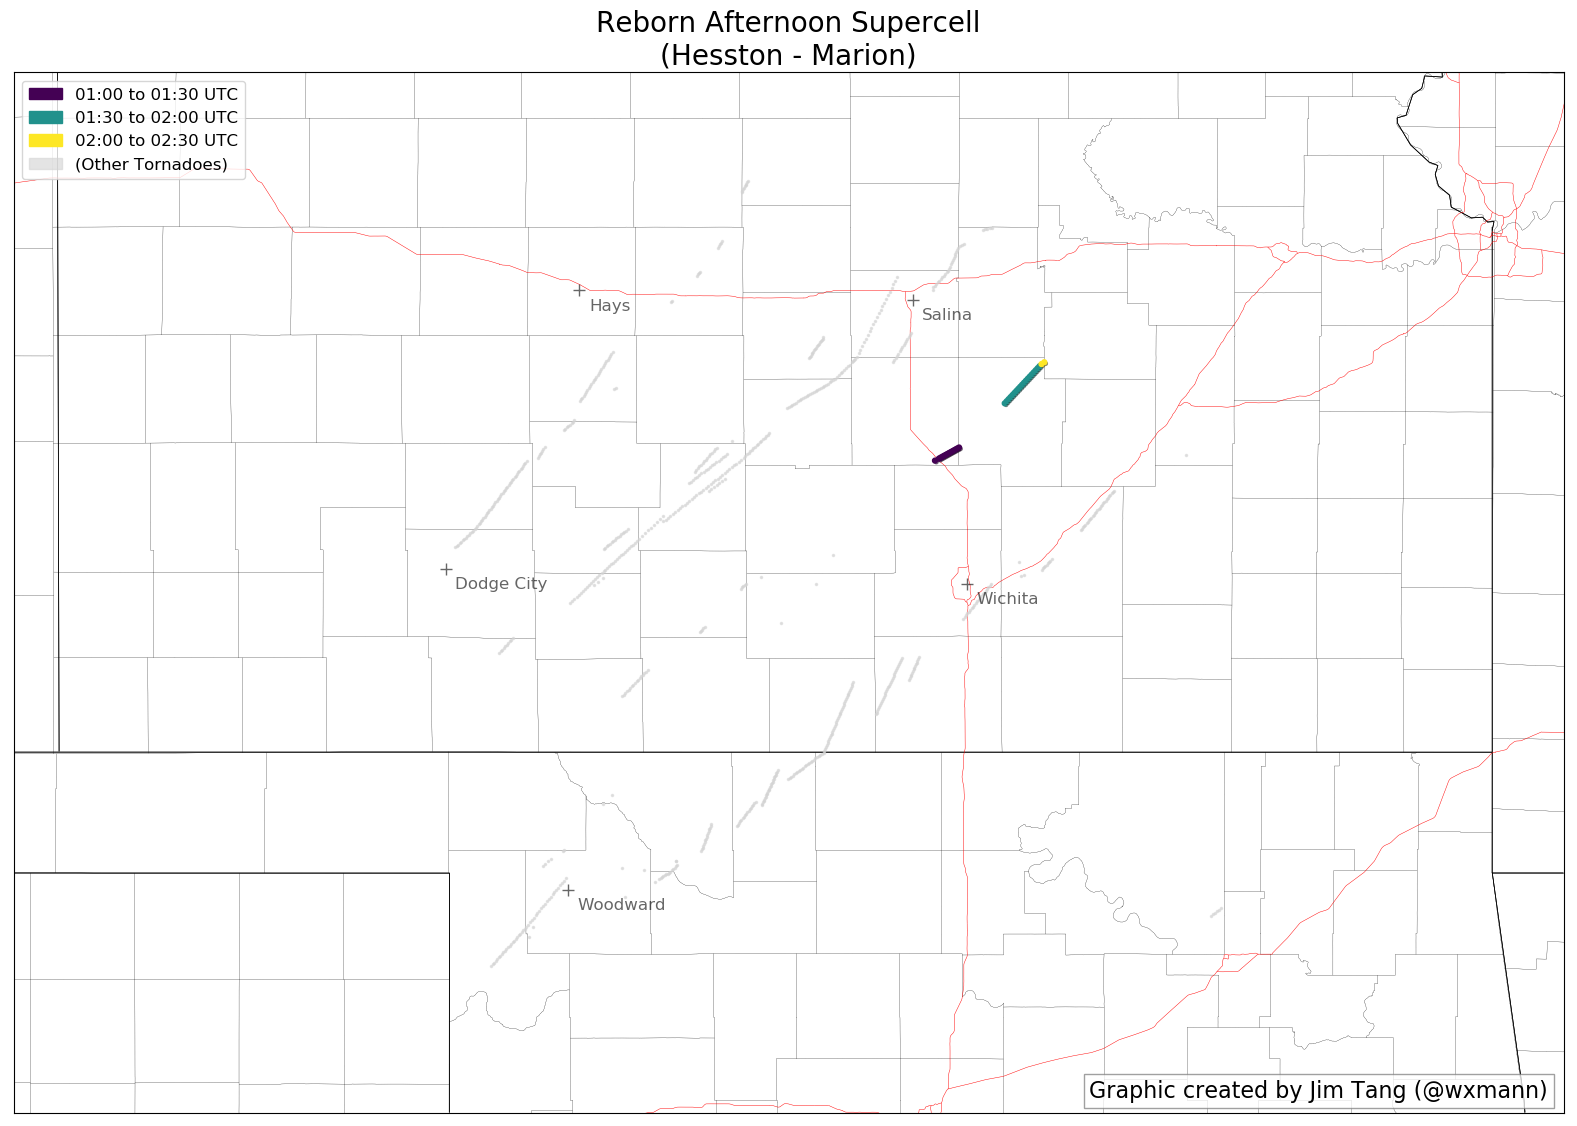

In [94]:
fig = plt.figure(figsize=(20, 20), dpi=100)

min_time = pd.Timestamp('2012-04-15 01:00+0000')
max_time = pd.Timestamp('2012-04-15 02:30+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

plot_cluster_progression(clust6, clusters, time_buckets)

plt.title('Reborn Afternoon Supercell'
          '\n(Hesston - Marion)',
         fontsize=20)
watermark(fig)
plt.show()

### Powerful Kansas Nocturnal Supercell: Greensburg - Macksville - St. John

In [87]:
clust7 = clusters.clusters[7]
clust7.summary()

{'center': (37.97073846153847, -98.84835192307689),
 'max_time': Timestamp('2012-04-15 03:00:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-15 01:27:00+0000', tz='UTC'),
 'size': 104,
 'time_spread': Timedelta('0 days 01:33:00')}

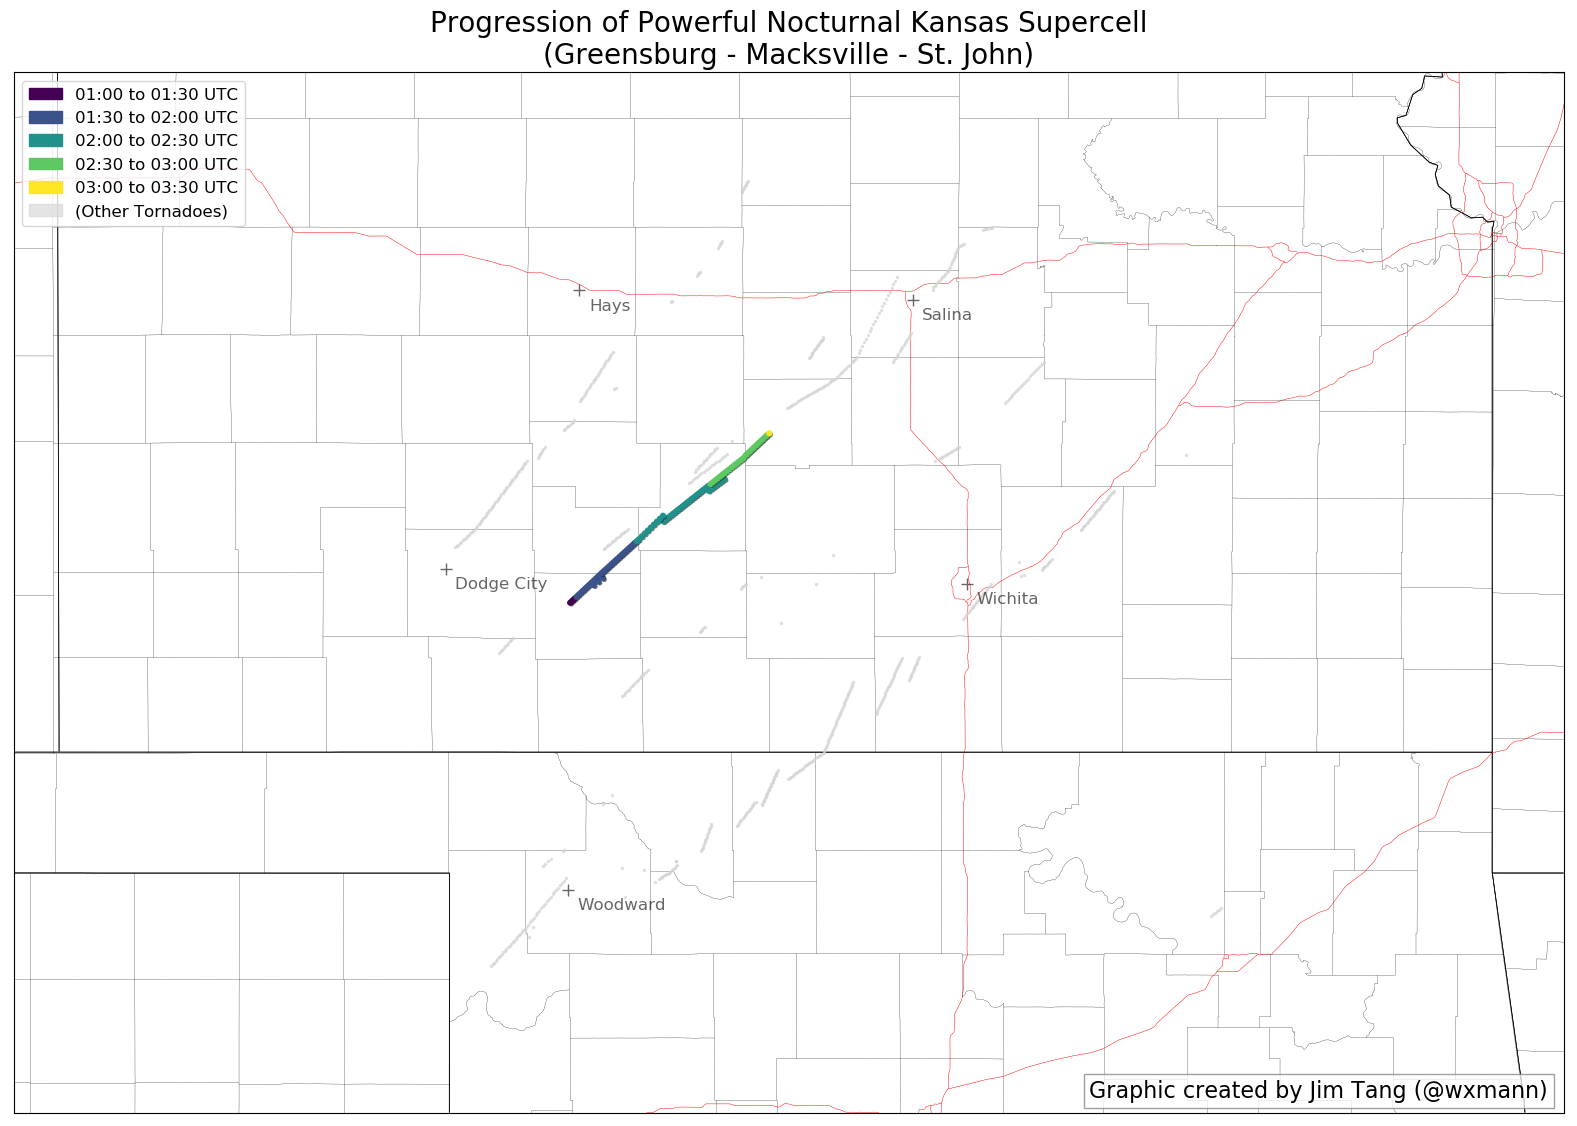

In [92]:
fig = plt.figure(figsize=(20, 20), dpi=100)

min_time = pd.Timestamp('2012-04-15 01:00+0000')
max_time = pd.Timestamp('2012-04-15 03:30+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

plot_cluster_progression(clust7, clusters, time_buckets)

plt.title('Progression of Powerful Nocturnal Kansas Supercell'
          '\n(Greensburg - Macksville - St. John)',
         fontsize=20)
watermark(fig)
plt.show()